### Project Members: Naman Jain(nj2387), Syed Sarfaraz Akhtar(ssa2184), Varun Chanddra(vc2491)

Model Folder: [Drive](https://drive.google.com/open?id=1U-u1qTOBkcQiEX49JLFBww-AN3yT4sk3)

GitHub Link: [GitHub](https://github.com/toshi1801/applied_dl_project)

Demo: [YouTube](https://youtu.be/YUwZXfL4RXQ)

This notebook trains 4 models by using 2 images.

NOTE: This notebook was tranied on a system with 32GB RAM. Therefore, there is a possibility that it may crash on Colab. If you want to run the entire code end-to-end then:


*   use a system with such configurations i.e. RAM: 32GB
*   Only one image can be used for training.

Default: Have reduced the training set to 1 image to make it executable on colab.

This notebook is training and evaluating models. 
Testing is done in separate [notebook](https://github.com/toshi1801/applied_dl_project/blob/master/adl_project_evaluate.ipynb).



In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import copy
from PIL import Image
from skimage.color import rgb2gray

import math
from sklearn.utils import shuffle
import tensorflow as tf
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.metrics import mean_iou
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter

# DATA PREPARATION

In [0]:
def download_data(slide_path, tumor_mask_path):

    slide_url = 'https://storage.googleapis.com/applied_dl/data/{}'.format(slide_path)
    mask_url = 'https://storage.googleapis.com/applied_dl/data/{}'.format(tumor_mask_path) 

    # Download the whole slide image
    if not os.path.exists(slide_path):
      !curl -O $slide_url

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):
      !curl -O $mask_url

In [0]:
# While running on colab only 1 image is used for training.
train_list = [['tumor_091.tif','tumor_091_mask.tif']] # ['tumor_110.tif','tumor_110_mask.tif']
test_list = [['tumor_075.tif', 'tumor_075_mask.tif']] #['tumor_075.tif', 'tumor_075_mask.tif'], ['tumor_084.tif', 'tumor_084_mask.tif']

In [0]:
images = train_list + test_list
for image in images:
    slide = image[0]
    mask = image[1]
    download_data(slide, mask)

In [0]:
def load_slides(slide_path, tumor_mask_path):
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[0][0], 
                                                            slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    print("Slide includes %d levels" % len(slide.level_dimensions))
    for i in range(len(slide.level_dimensions)):
        print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                                 slide.level_dimensions[i], 
                                                                 slide.level_downsamples[i]))
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

    # Verify downsampling works as expected
    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
    return slide, tumor_mask

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def plot_tumor_slide(slide, level, plot_image=False):
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=slide.level_dimensions[level][0], 
                             height=slide.level_dimensions[level][1])

    if plot_image:
        plt.figure(figsize=(5,5), dpi=100)
        plt.imshow(slide_image)
    return slide_image

In [0]:
def plot_tumor_mask(slide, mask, level, plot_image=False):
    mask_image = read_slide(mask, 
                            x=0, 
                            y=0, 
                            level=level, 
                            width=slide.level_dimensions[level][0], 
                            height=slide.level_dimensions[level][1])

    mask_image = mask_image[:,:,0]
    
    if plot_image:
        plt.figure(figsize=(5,5), dpi=100)
        plt.imshow(mask_image)
    return mask_image

In [0]:
def overlay_slide_and_mask(slide_image, mask_image):
    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(slide_image)
    plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
def get_slide_and_mask_for_level(slide_list, level, overlay=False):
    slide_image_list = []
    mask_image_list = []
    for i in range(len(slide_list)):
        slide_image = plot_tumor_slide(slide_list[i][0], level)
        mask_image = plot_tumor_mask(slide_list[i][0], slide_list[i][1], level)
        slide_image_list.append(slide_image)
        mask_image_list.append(mask_image)
        if overlay:
            overlay_slide_and_mask(slide_image, mask_image)
    return slide_image_list, mask_image_list

In [0]:
frame_size = 100
frame_width , frame_height = frame_size, frame_size

center = 60
lower = int(math.floor(frame_size - center) / 2)
upper = int(math.ceil(frame_size - center) / 2)

In [0]:
def get_label(mask_image, x, y):
    if mask_image[x + lower : x + frame_width - upper, y + lower: y + frame_height - upper].sum() > 0:
        return 1
    return 0

In [0]:
def extract_slide_frames(slide_image, mask_image):
    images = []
    labels = []
    width, height = slide_image.shape[0], slide_image.shape[1]
    for i in range(0, width - frame_width + 1, frame_size):
        for j in range(0, height - frame_height + 1, frame_size):
            image = slide_image[i : i + frame_width, j : j +  frame_height, :]
            images.append(image)
            label = get_label(mask_image, i, j)
            labels.append(label)
    images = np.asarray(images)
    labels = np.asarray(labels)
    return images, labels

In [0]:
def sampling(images, labels):
    n = int(len(labels) - labels.sum())
    sample_indices = np.where(labels == 1)[0]
    
    sample_keys = np.random.choice(sample_indices, size=n, replace=True)
    x = np.append(images[sample_keys], images[np.where(labels == 0)], axis=0)
    y = np.append(labels[sample_keys], labels[np.where(labels == 0)])
    x, y = shuffle(x, y, random_state=42)
    print(x.shape, y.shape)
    print('tumor percent : {}'.format(y.sum() / len(y)))
    return x, y

In [0]:
def generate_train_dataset(train_slide_image_list, train_mask_image_list):
    train_array = []
    for i in range(len(train_slide_image_list)):
        x_train_initial, y_train_initial = extract_slide_frames(train_slide_image_list[i], train_mask_image_list[i])
        train_array.append([x_train_initial, y_train_initial])

    x_train = train_array[0][0]
    y_train = train_array[0][1]

    for i in range(1, len(train_array)):
        x_train = np.append(x_train, train_array[i][0], axis=0)
        y_train = np.append(y_train, train_array[i][1])

    print(x_train.shape, y_train.shape)
    

    print(Counter(y_train).keys())
    print(Counter(y_train).values())
    
    x_train_sampled, y_train_sampled = sampling(x_train, y_train)

    x_train_over, x_val_over, y_train_over, y_val_over = train_test_split(x_train_sampled, 
                                                                          y_train_sampled, 
                                                                          test_size=0.3, 
                                                                          stratify=y_train_sampled, 
                                                                          random_state=42)    
    return x_train_over, y_train_over, x_val_over, y_val_over


def generate_test_dataset(test_slide_image_list, test_mask_image_list):
    test_array = []
    for i in range(len(test_slide_image_list)):
        x_test, y_test = extract_slide_frames(test_slide_image_list[i], test_mask_image_list[i])
        test_array.append([x_test, y_test])

    for test in test_array:
        print(test[0].shape, test[1].shape)
    return test_array

In [0]:
def get_datagen(x_train, y_train, x_val, y_val):
    train_datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(x_val, y_val, batch_size=32)
    
    return train_generator, val_generator

# MODEL CONFIGURATION

In [0]:
def configure_model(base):
    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-4),
                 loss = 'binary_crossentropy',
                 metrics = ['acc'])
    model.summary()
    return model

In [0]:
def train_model(model, x_train, train_generator, val_generator, batch_size, epochs):
    model.fit_generator(train_generator, 
                        steps_per_epoch=len(x_train)//batch_size,
                        epochs=epochs,
                        validation_data=val_generator)
    return model

In [0]:
def evaluate_model(model, x_test, y_test):
        
    scores = model.evaluate(x_test, y_test)
    y_predict = model.predict(x_test)
    y_predict_prob = model.predict_proba(x_test)
    y_predict_label = model.predict_classes(x_test)
    print(y_predict_label.shape)
    
    print('Loss: ', scores[0])
    print('Acc: ', scores[1])
    print('Precision: ', precision_score(y_test, y_predict_label))
    print('Recall: ', recall_score(y_test, y_predict_label))
    print('F1: ', f1_score(y_test, y_predict_label))
    print('AUCROC: ', roc_auc_score(y_test, y_predict_label))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_predict_label))
    
    return y_predict_label, y_predict_prob

# TRAINING

In [0]:
train_slide_list  = []
for i in range(len(train_list)):
    train_slide, train_mask = load_slides(train_list[i][0],train_list[i][1])
    train_slide_list.append([train_slide,train_mask])

Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif
Slide includes 9 levels
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256
Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360

In [0]:
train_slide_image_list, train_mask_image_list = get_slide_and_mask_for_level(train_slide_list, 3)

In [0]:
x_train_over, y_train_over, x_val_over, y_val_over = generate_train_dataset(train_slide_image_list, train_mask_image_list)
print(x_train_over.shape, y_train_over.shape, x_val_over.shape, y_val_over.shape)

train_generator, val_generator = get_datagen(x_train_over, y_train_over, x_val_over, y_val_over)

(15505, 100, 100, 3) (15505,)
dict_keys([0, 1])
dict_values([13523, 1982])
(27046, 100, 100, 3) (27046,)
tumor percent : 0.5
(18932, 100, 100, 3) (18932,) (8114, 100, 100, 3) (8114,)


In [0]:
train_slide_image_list_level_5, train_mask_image_list_level_5 = get_slide_and_mask_for_level(train_slide_list, 5)

In [0]:
x_train_over_level_5, y_train_over_level_5, x_val_over_level_5, y_val_over_level_5 = generate_train_dataset(train_slide_image_list_level_5, train_mask_image_list_level_5)
print(x_train_over_level_5.shape, y_train_over_level_5.shape, x_val_over_level_5.shape, y_val_over_level_5.shape)

train_generator_level_5, val_generator_level_5 = get_datagen(x_train_over_level_5, y_train_over_level_5, x_val_over_level_5, y_val_over_level_5)

(942, 100, 100, 3) (942,)
dict_keys([0, 1])
dict_values([787, 155])
(1574, 100, 100, 3) (1574,)
tumor percent : 0.5
(1101, 100, 100, 3) (1101,) (473, 100, 100, 3) (473,)


## Model 1_a

**Base Model:** InceptionV3

**Train data resolution level:** 3

In [0]:
base_incep = tf.keras.applications.InceptionV3(weights='imagenet', 
                                             include_top=False, 
                                             input_shape=(100, 100, 3))
base_incep.trainables = False
new_model_incep_level_3 = configure_model(base_incep)

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 24s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,

In [0]:
new_model_incep_level_3 = train_model(new_model_incep_level_3, x_train_over, train_generator, val_generator, 32, 5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
592/592 [==============================] - 77s 130ms/step - loss: 0.1401 - acc: 0.9427 - val_loss: 0.0502 - val_acc: 0.9836
Epoch 2/5
592/592 [==============================] - 67s 113ms/step - loss: 0.0414 - acc: 0.9860 - val_loss: 0.0274 - val_acc: 0.9899
Epoch 3/5
592/592 [==============================] - 68s 115ms/step - loss: 0.0284 - acc: 0.9910 - val_loss: 0.0217 - val_acc: 0.9935
Epoch 4/5
592/592 [==============================] - 67s 114ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.0199 - val_acc: 0.9949
Epoch 5/5
592/592 [==============================] - 68s 115ms/step - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0118 - val_acc: 0.9961


In [0]:
# !rm -rf model1_a
# !mkdir model1_a

In [0]:
# model1_a_path = tf.contrib.saved_model.save_keras_model(new_model_incep_level_3, 'model1_a')
# print(model1_a_path)

## Model 1_b

**Base Model:** InceptionV3

**Train data resolution level:** 5

In [0]:
new_model_incep_level_5 = configure_model(base_incep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


In [0]:
new_model_incep_level_5 = train_model(new_model_incep_level_5, x_train_over_level_5, train_generator_level_5, val_generator_level_5, 32, 5)

Epoch 1/5
35/35 [==============================] - 12s 346ms/step - loss: 0.1877 - acc: 0.9310 - val_loss: 0.0909 - val_acc: 0.9746
Epoch 2/5
35/35 [==============================] - 4s 120ms/step - loss: 0.0345 - acc: 0.9909 - val_loss: 0.0318 - val_acc: 0.9937
Epoch 3/5
35/35 [==============================] - 4s 123ms/step - loss: 0.0143 - acc: 0.9964 - val_loss: 0.0282 - val_acc: 0.9915
Epoch 4/5
35/35 [==============================] - 4s 121ms/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0099 - val_acc: 0.9979
Epoch 5/5
35/35 [==============================] - 4s 116ms/step - loss: 0.0239 - acc: 0.9946 - val_loss: 0.0156 - val_acc: 0.9958


In [0]:
# !rm -rf model1_b
# !mkdir model1_b

In [0]:
# model1_b_path = tf.contrib.saved_model.save_keras_model(new_model_incep_level_5, 'model1_b')
# print(model1_b_path)

## Model 2_a

**Base Model:** ResNet50

**Train data resolution level:** 3

In [0]:
base_resnet50 = tf.keras.applications.ResNet50(weights='imagenet', 
                                               include_top=False, 
                                               input_shape=(100, 100, 3))
base_resnet50.trainables = False
new_model_resnet50_level_3 = configure_model(base_resnet50)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
new_model_resnet50_level_3 = train_model(new_model_resnet50_level_3, x_train_over, train_generator, val_generator, 32, 5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
592/592 [==============================] - 98s 166ms/step - loss: 0.0552 - acc: 0.9806 - val_loss: 0.0140 - val_acc: 0.9959
Epoch 2/5
592/592 [==============================] - 91s 153ms/step - loss: 0.0164 - acc: 0.9953 - val_loss: 0.0095 - val_acc: 0.9970
Epoch 3/5
592/592 [==============================] - 91s 153ms/step - loss: 0.0106 - acc: 0.9973 - val_loss: 0.0088 - val_acc: 0.9977
Epoch 4/5
592/592 [==============================] - 90s 153ms/step - loss: 0.0101 - acc: 0.9976 - val_loss: 0.0128 - val_acc: 0.9968
Epoch 5/5
592/592 [==============================] - 91s 153ms/step - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0073 - val_acc: 0.9977


In [0]:
# !rm -rf model2_a
# !mkdir model2_a

In [0]:
# model2_a_path = tf.contrib.saved_model.save_keras_model(new_model_resnet50_level_3, 'model2_a')
# print(model2_a_path)

## Model 2_b

**Base Model:** ResNet50

**Train data resolution level:** 5

In [0]:
new_model_resnet50_level_5 = configure_model(base_resnet50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
new_model_resnet50_level_5 = train_model(new_model_resnet50_level_5, x_train_over_level_5, train_generator_level_5, val_generator_level_5, 32, 5)

Epoch 1/5
35/35 [==============================] - 12s 331ms/step - loss: 0.0954 - acc: 0.9682 - val_loss: 0.0379 - val_acc: 0.9915
Epoch 2/5
35/35 [==============================] - 5s 153ms/step - loss: 0.0441 - acc: 0.9900 - val_loss: 0.1521 - val_acc: 0.9704
Epoch 3/5
35/35 [==============================] - 6s 157ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9915
Epoch 4/5
35/35 [==============================] - 6s 159ms/step - loss: 0.0046 - acc: 0.9973 - val_loss: 0.0171 - val_acc: 0.9937
Epoch 5/5
35/35 [==============================] - 5s 155ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9979


In [0]:
# !rm -rf model2_b
# !mkdir model2_b

In [0]:
# model2_b_path = tf.contrib.saved_model.save_keras_model(new_model_resnet50_level_5, 'model2_b')
# print(model2_b_path)

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [0]:
# !zip -r model2_a.zip model2_a
# !zip -r model2_b.zip model2_b

  adding: model2_a/ (stored 0%)
  adding: model2_a/1558050741/ (stored 0%)
  adding: model2_a/1558050741/assets/ (stored 0%)
  adding: model2_a/1558050741/assets/saved_model.json (deflated 96%)
  adding: model2_a/1558050741/saved_model.pb (deflated 93%)
  adding: model2_a/1558050741/variables/ (stored 0%)
  adding: model2_a/1558050741/variables/variables.index (deflated 82%)
  adding: model2_a/1558050741/variables/checkpoint (deflated 37%)
  adding: model2_a/1558050741/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model2_b/ (stored 0%)
  adding: model2_b/1558050788/ (stored 0%)
  adding: model2_b/1558050788/assets/ (stored 0%)
  adding: model2_b/1558050788/assets/saved_model.json (deflated 96%)
  adding: model2_b/1558050788/saved_model.pb (deflated 93%)
  adding: model2_b/1558050788/variables/ (stored 0%)
  adding: model2_b/1558050788/variables/variables.index (deflated 82%)
  adding: model2_b/1558050788/variables/checkpoint (deflated 37%)
  adding: model2_b/155805078

# EVALUATION
This evaluation is just to test the trained models on the fly.
We have a separate evaluation notebook.

In [0]:
test_slide_list = []
for i in range(len(test_list)):
    test_slide, test_mask = load_slides(test_list[i][0],test_list[i][1])
    test_slide_list.append([test_slide, test_mask])

Read WSI from tumor_075.tif with width: 90112, height: 78848
Read tumor mask from tumor_075_mask.tif
Slide includes 9 levels
Level 0, dimensions: (90112, 78848) downsample factor 1
Level 1, dimensions: (45056, 39424) downsample factor 2
Level 2, dimensions: (22528, 19712) downsample factor 4
Level 3, dimensions: (11264, 9856) downsample factor 8
Level 4, dimensions: (5632, 4928) downsample factor 16
Level 5, dimensions: (2816, 2464) downsample factor 32
Level 6, dimensions: (1408, 1232) downsample factor 64
Level 7, dimensions: (704, 616) downsample factor 128
Level 8, dimensions: (352, 308) downsample factor 256


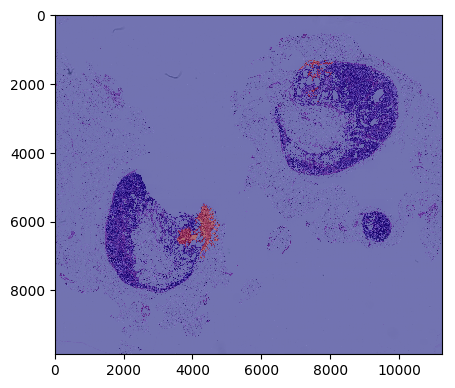

In [0]:
test_slide_image_list, test_mask_image_list = get_slide_and_mask_for_level(test_slide_list, 3, overlay=True)

In [0]:
test_sample = generate_test_dataset(test_slide_image_list, test_mask_image_list)

(10976, 100, 100, 3) (10976,)


In [0]:
test_image_1 = test_sample[0]
test_slide_image_1 = test_slide_image_list[0]

In [0]:
def evaluate_image(model, test_image, test_slide_image):
    incep_predict_label, incep_predict_prob = evaluate_model(model, test_image[0], test_image[1])

    with tf.Session() as session:
        iou, conf_mat = tf.metrics.mean_iou(tf.convert_to_tensor(test_image[1].reshape((test_image[1].shape[0], 1))), 
                                            tf.convert_to_tensor(incep_predict_label), num_classes=2)
        session.run(tf.local_variables_initializer())
        session.run([conf_mat])
        miou = session.run([iou])
        print(miou)
    
    return incep_predict_label, incep_predict_prob

## Model 1_a

In [0]:
incep_predict_label_level_3, incep_predict_prob_level_3 = evaluate_image(new_model_incep_level_3, test_image_1, test_slide_image_1)

10976/10976 [==============================] - 8s 769us/sample - loss: 0.1228 - acc: 0.9863
(10976, 1)
Loss:  0.12283631841492837
Acc:  0.98633385
Precision:  0.6190476190476191
Recall:  0.1625
F1:  0.25742574257425743
AUCROC:  0.5805103550295859
Confusion Matrix: 
 [[10800    16]
 [  134    26]]
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[0.56701434]


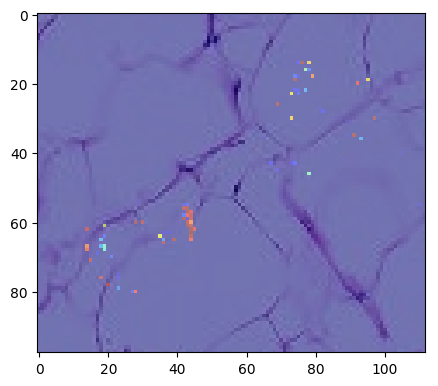

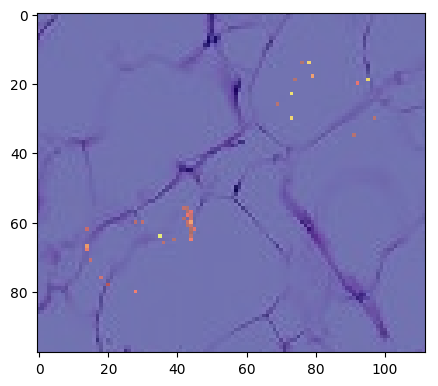

In [0]:
incep_prob_image_level_3 = np.reshape(incep_predict_prob_level_3, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, incep_prob_image_level_3)

incep_prob_image_level_3_threshold = copy.deepcopy(incep_prob_image_level_3)
super_threshold_indices = incep_prob_image_level_3_threshold < 0.6
incep_prob_image_level_3_threshold[super_threshold_indices] = 0

overlay_slide_and_mask(test_slide_image_1, incep_prob_image_level_3_threshold)

## Model 1_b

In [0]:
incep_predict_label_level_5, incep_predict_prob_level_5 = evaluate_image(new_model_incep_level_5, test_image_1, test_slide_image_1)

10976/10976 [==============================] - 8s 755us/sample - loss: 0.0778 - acc: 0.9857
(10976, 1)
Loss:  0.07775138716985378
Acc:  0.9856961
Precision:  0.5272727272727272
Recall:  0.18125
F1:  0.2697674418604651
AUCROC:  0.5894230769230769
Confusion Matrix: 
 [[10790    26]
 [  131    29]]
[0.57078606]


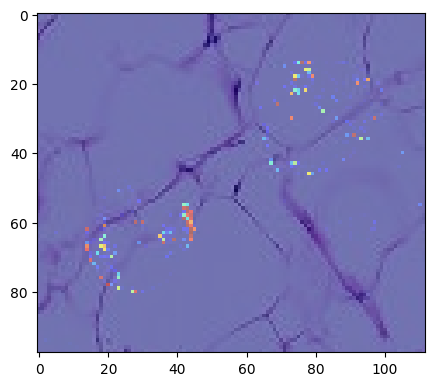

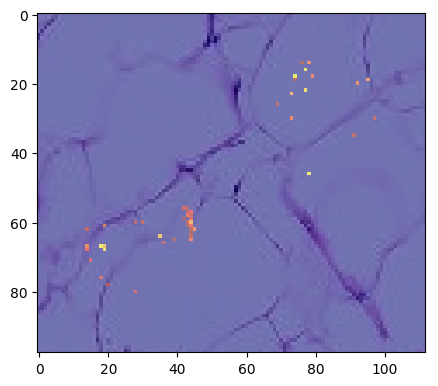

In [0]:
incep_prob_image_level_5 = np.reshape(incep_predict_prob_level_5, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, incep_prob_image_level_5)

incep_prob_image_level_5_threshold = copy.deepcopy(incep_prob_image_level_5)
super_threshold_indices = incep_prob_image_level_5_threshold < 0.6
incep_prob_image_level_5_threshold[super_threshold_indices] = 0

overlay_slide_and_mask(test_slide_image_1, incep_prob_image_level_5_threshold)

## Ensemble:  Model 1_a +  Model 1_b

In [0]:
incep_predict_prob_avg = (np.array(incep_prob_image_level_3_threshold) + np.array(incep_prob_image_level_5_threshold)) / 2

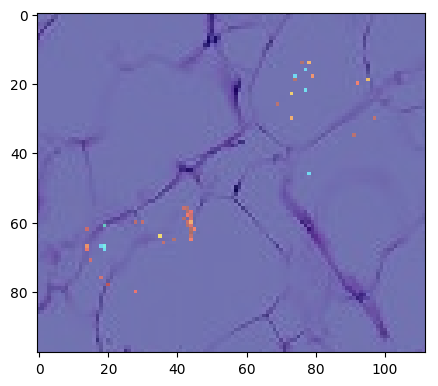

In [0]:
incep_prob_image_avg = np.reshape(incep_predict_prob_avg, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, incep_prob_image_avg)

## Model 2_a

In [0]:
resnet50_predict_label_level_3, resnet50_predict_prob_level_3 = evaluate_image(new_model_resnet50_level_3, test_image_1, test_slide_image_1)

10976/10976 [==============================] - 12s 1ms/sample - loss: 0.1270 - acc: 0.9790
(10976, 1)
Loss:  0.12695432959342423
Acc:  0.9790452
Precision:  0.325
Recall:  0.40625
F1:  0.36111111111111116
AUCROC:  0.6968842455621301
Confusion Matrix: 
 [[10681   135]
 [   95    65]]
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
[0.59962964]


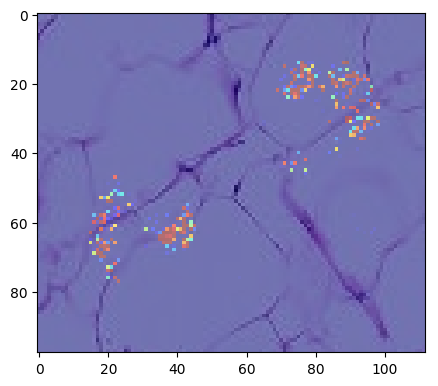

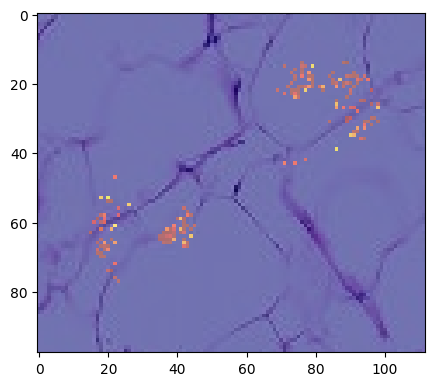

In [0]:
resnet50_prob_image_level_3 = np.reshape(resnet50_predict_prob_level_3, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, resnet50_prob_image_level_3)

resnet50_prob_image_level_3_threshold = copy.deepcopy(resnet50_prob_image_level_3)
super_threshold_indices = resnet50_prob_image_level_3_threshold < 0.65
resnet50_prob_image_level_3_threshold[super_threshold_indices] = 0

overlay_slide_and_mask(test_slide_image_1, resnet50_prob_image_level_3_threshold)

## Model 2_b

In [0]:
resnet50_predict_label_level_5, resnet50_predict_prob_level_5 = evaluate_image(new_model_resnet50_level_5, test_image_1, test_slide_image_1)

10976/10976 [==============================] - 12s 1ms/sample - loss: 0.1104 - acc: 0.9800
(10976, 1)
Loss:  0.11042424077835405
Acc:  0.97995627
Precision:  0.32954545454545453
Recall:  0.3625
F1:  0.34523809523809523
AUCROC:  0.6757951183431953
Confusion Matrix: 
 [[10698   118]
 [  102    58]]
[0.59424144]


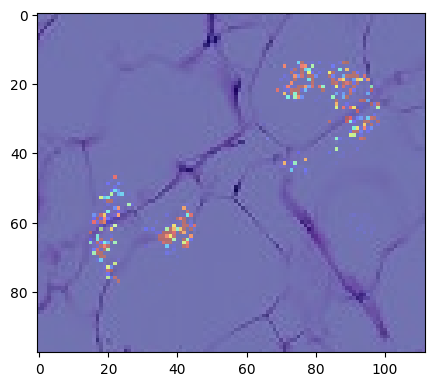

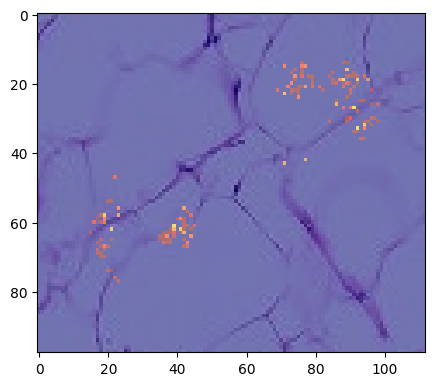

In [0]:
resnet50_prob_image_level_5 = np.reshape(resnet50_predict_prob_level_5, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, resnet50_prob_image_level_5)

resnet50_prob_image_level_5_threshold = copy.deepcopy(resnet50_prob_image_level_5)
super_threshold_indices = resnet50_prob_image_level_5_threshold < 0.65
resnet50_prob_image_level_5_threshold[super_threshold_indices] = 0

overlay_slide_and_mask(test_slide_image_1, resnet50_prob_image_level_5_threshold)

## Ensemble: Model2_a + Model2_b

In [0]:
resnet50_predict_prob_avg = (np.array(resnet50_prob_image_level_3_threshold) + np.array(resnet50_prob_image_level_5_threshold)) / 2

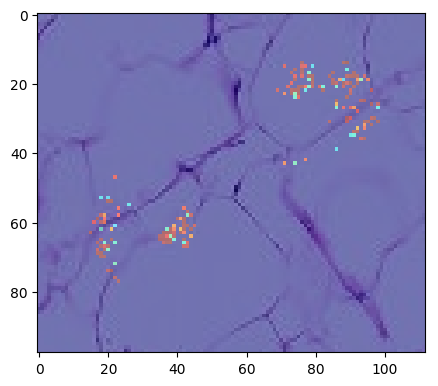

In [0]:
resnet50_prob_image_avg = np.reshape(resnet50_predict_prob_avg, (-1, 112))
overlay_slide_and_mask(test_slide_image_1, resnet50_prob_image_avg)